In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from neural_network_lib.neural_network import NeuralNetwork

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay

In [4]:
path = "../../datasets/dog"
files_move = sorted(glob.glob(path + "/clean_dog_move*.csv"))
file_info = "DogInfo.csv"

##### Carregando o dataset **DogMoveData**  limpo e converte os tipos das colunas para economizar memória

In [5]:
df_move = pd.concat((pd.read_csv(file_move) for file_move in files_move), ignore_index=True)
df_move = df_move.astype({col: 'float32' if df_move[col].dtype == 'float64' else 
                       'int32' if df_move[col].dtype == 'int64' else 
                        df_move[col].dtype for col in df_move.columns})

df_move.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556827 entries, 0 to 6556826
Data columns (total 14 columns):
 #   Column    Dtype  
---  ------    -----  
 0   DogID     int32  
 1   ABack_x   float32
 2   ABack_y   float32
 3   ABack_z   float32
 4   ANeck_x   float32
 5   ANeck_y   float32
 6   ANeck_z   float32
 7   GBack_x   float32
 8   GBack_y   float32
 9   GBack_z   float32
 10  GNeck_x   float32
 11  GNeck_y   float32
 12  GNeck_z   float32
 13  Behavior  object 
dtypes: float32(12), int32(1), object(1)
memory usage: 375.2+ MB


##### Carregando o dataset **DogInfo** e converte os tipos das colunas para economizar memória

In [6]:
df_info = pd.read_csv(f"{path}/{file_info}")
df_info = df_info.drop(columns=['Breed', 'Age months', 'NeuteringStatus'])
df_info = df_info.astype({col: 'int32' if df_info[col].dtype == 'int64' else
                        df_info[col].dtype for col in df_info.columns})

df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   DogID   45 non-null     int32
 1   Weight  45 non-null     int32
 2   Gender  45 non-null     int32
dtypes: int32(3)
memory usage: 672.0 bytes


In [7]:
df_merged = df_info.merge(df_move, on='DogID', how='inner')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556827 entries, 0 to 6556826
Data columns (total 16 columns):
 #   Column    Dtype  
---  ------    -----  
 0   DogID     int32  
 1   Weight    int32  
 2   Gender    int32  
 3   ABack_x   float32
 4   ABack_y   float32
 5   ABack_z   float32
 6   ANeck_x   float32
 7   ANeck_y   float32
 8   ANeck_z   float32
 9   GBack_x   float32
 10  GBack_y   float32
 11  GBack_z   float32
 12  GNeck_x   float32
 13  GNeck_y   float32
 14  GNeck_z   float32
 15  Behavior  object 
dtypes: float32(12), int32(3), object(1)
memory usage: 425.2+ MB


##### Removendo classes que possuem pouca frequência

In [8]:
counts = df_merged['Behavior'].value_counts()

frequent_behaviors = counts[counts > 400_000].index

df_filtered = df_merged[df_merged['Behavior'].isin(frequent_behaviors)].reset_index(drop=True)

df_balanced = (
    df_filtered.groupby('Behavior', group_keys=False)
    .sample(n=1000, random_state=42, replace=False)
    .reset_index(drop=True)
)
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DogID     8000 non-null   int32  
 1   Weight    8000 non-null   int32  
 2   Gender    8000 non-null   int32  
 3   ABack_x   8000 non-null   float32
 4   ABack_y   8000 non-null   float32
 5   ABack_z   8000 non-null   float32
 6   ANeck_x   8000 non-null   float32
 7   ANeck_y   8000 non-null   float32
 8   ANeck_z   8000 non-null   float32
 9   GBack_x   8000 non-null   float32
 10  GBack_y   8000 non-null   float32
 11  GBack_z   8000 non-null   float32
 12  GNeck_x   8000 non-null   float32
 13  GNeck_y   8000 non-null   float32
 14  GNeck_z   8000 non-null   float32
 15  Behavior  8000 non-null   object 
dtypes: float32(12), int32(3), object(1)
memory usage: 531.4+ KB


##### Encoding da variável alvo

In [9]:
le = LabelEncoder()
df_balanced['Behavior'] = le.fit_transform(df_balanced['Behavior'])

##### Mapeamento dos rótulos originais de `Behavior` para seus valores codificados

In [10]:
dict(zip(le.classes_, le.transform(le.classes_)))

{'Lying chest': np.int64(0),
 'Panting': np.int64(1),
 'Playing': np.int64(2),
 'Sitting': np.int64(3),
 'Sniffing': np.int64(4),
 'Standing': np.int64(5),
 'Trotting': np.int64(6),
 'Walking': np.int64(7)}

##### Separando entre ``features`` e ``target``

In [11]:
X = df_balanced.drop(columns=['DogID', 'Behavior'])
y = df_balanced['Behavior']

In [13]:
X_scaled = StandardScaler().fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [15]:
nn = NeuralNetwork(hidden_layers=(64, 32, 16, 8), 
                   hidden_activation=['relu', 'relu', 'relu', 'relu'],
                   loss='cce',
                   model_type='multiclass',
                   learning_rate=0.05,
                   max_iter=100000)


0.05


In [50]:
nn.fit(X_train, y_train)

['relu', 'relu', 'relu', 'relu', 'softmax']
Epoch 0, Loss: 2.8282889212297233
Epoch 1000, Loss: 0.7655245750345102
Epoch 2000, Loss: 0.5976204235714782
Epoch 3000, Loss: 0.49627537871428745
Epoch 4000, Loss: 0.42671685124756126
Epoch 5000, Loss: 0.40543679636714614
Epoch 6000, Loss: 0.3861128434446738
Epoch 7000, Loss: 0.32067615929671006
Epoch 8000, Loss: 0.270468140930422
Epoch 9000, Loss: 0.2215150886326514
Epoch 10000, Loss: 0.24796071495857036
Epoch 11000, Loss: 0.5672182943459578
Epoch 12000, Loss: 0.17270724308095062
Epoch 13000, Loss: 0.15745347220928826
Epoch 14000, Loss: 0.4431067966035694
Epoch 15000, Loss: 0.14150717468699453
Epoch 16000, Loss: 0.13714822395140636
Epoch 17000, Loss: 0.33682584251779646
Epoch 18000, Loss: 0.10424915945723236
Epoch 19000, Loss: 0.10055760192920815
Epoch 20000, Loss: 0.09477037403067051
Epoch 21000, Loss: 0.09866056397056905
Epoch 22000, Loss: 0.08023550664838716
Epoch 23000, Loss: 0.07052161673034306
Epoch 24000, Loss: 0.06919769762602533
Epo

In [ ]:
nn_pred = nn.predict(X_test)

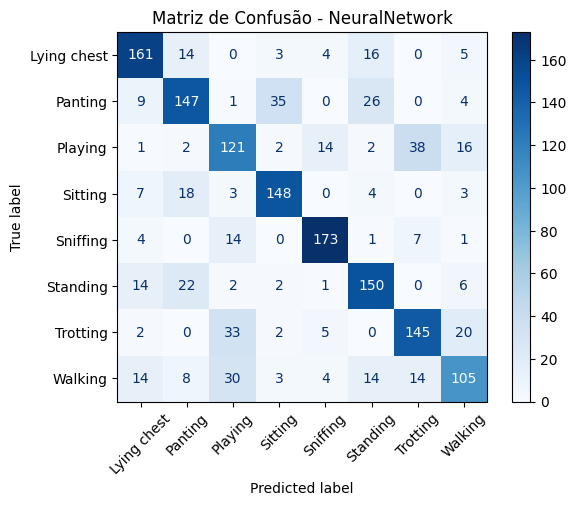

              precision    recall  f1-score   support

 Lying chest       0.76      0.79      0.78       203
     Panting       0.70      0.66      0.68       222
     Playing       0.59      0.62      0.60       196
     Sitting       0.76      0.81      0.78       183
    Sniffing       0.86      0.86      0.86       200
    Standing       0.70      0.76      0.73       197
    Trotting       0.71      0.70      0.71       207
     Walking       0.66      0.55      0.60       192

    accuracy                           0.72      1600
   macro avg       0.72      0.72      0.72      1600
weighted avg       0.72      0.72      0.72      1600

Acurácia: 0.71875


In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, nn_pred, display_labels=le.classes_, cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão - NeuralNetwork")
plt.show()

print(classification_report(y_test, nn_pred, target_names=le.classes_))
print("Acurácia:", accuracy_score(y_test, nn_pred))
